In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 200
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

# Quickstart Tutorial

In [3]:
import coronagraph as cg
print(cg.__version__)

0.0.2


In [4]:
cg.plot_setup.setup()

First, we'll set up the `Telescope`, `Planet`, and `Star` by instantiating them with their default values. 

In [5]:
telescope = cg.Telescope()
print(telescope)

Coronagraph: 
------------
- Telescope observing mode : IFS
- Minimum wavelength (um) : 0.3
- Maximum wavelength (um)  : 2.0
- Spectral resolution (lambda / delta-lambda)  : 70.0 
- Telescope/System temperature (K)  : 260.0 
- Detector temperature (K)  : 50.0 
- Telescope diameter (m)  : 8.0 
- Telescope emissivity  : 0.9 
- Inner Working Angle (lambda/D)  : 0.5 
- Outer Working Angle (lambda/D)  : 30000.0 
- Telescope throughput  : 0.2 
- Raw Contrast  : 1e-10 
- Dark current (s**-1)  : 0.0001 
- Horizontal pixel spread of IFS spectrum  : 3.0 
- Read noise per pixel  : 0.1 
- Maximum exposure time (hr)  : 1.0 
- Size of photometric aperture (lambda/D)  : 0.7 
- Quantum efficiency  : 0.9


In [6]:
planet = cg.Planet()
print(planet)

Planet: 
-------
- Planet name  : earth
- Stellar type of planet host star : sun
- Distance to system (pc) : 10.0
- Number of exzodis (zodis) : 1.0
- Radius of planet (Earth Radii) : 1.0
- Semi-major axis (AU) : 1.0
- Phase angle (deg) : 90.0
- Lambertian phase function : 0.318309886184
- Zodiacal light surface brightness (mag/arcsec**2) : 23.0
- Exozodiacal light surface brightness (mag/arcsec**2) : 22.0


In [7]:
star = cg.Star()
print(star)

Star: 
-----
- Effective Temperature (K) : 5780.0
- Radius (Solar Radii) : 1.0


Now let's load in a high resolution model of the Earth's spectrum from [Robinson et al. (2011)](http://adsabs.harvard.edu/abs/2011AsBio..11..393R), 

In [8]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

and we can take a look at the disk-integrated geomtric albedo spectrum of the Earth with realistic cloud coverage:

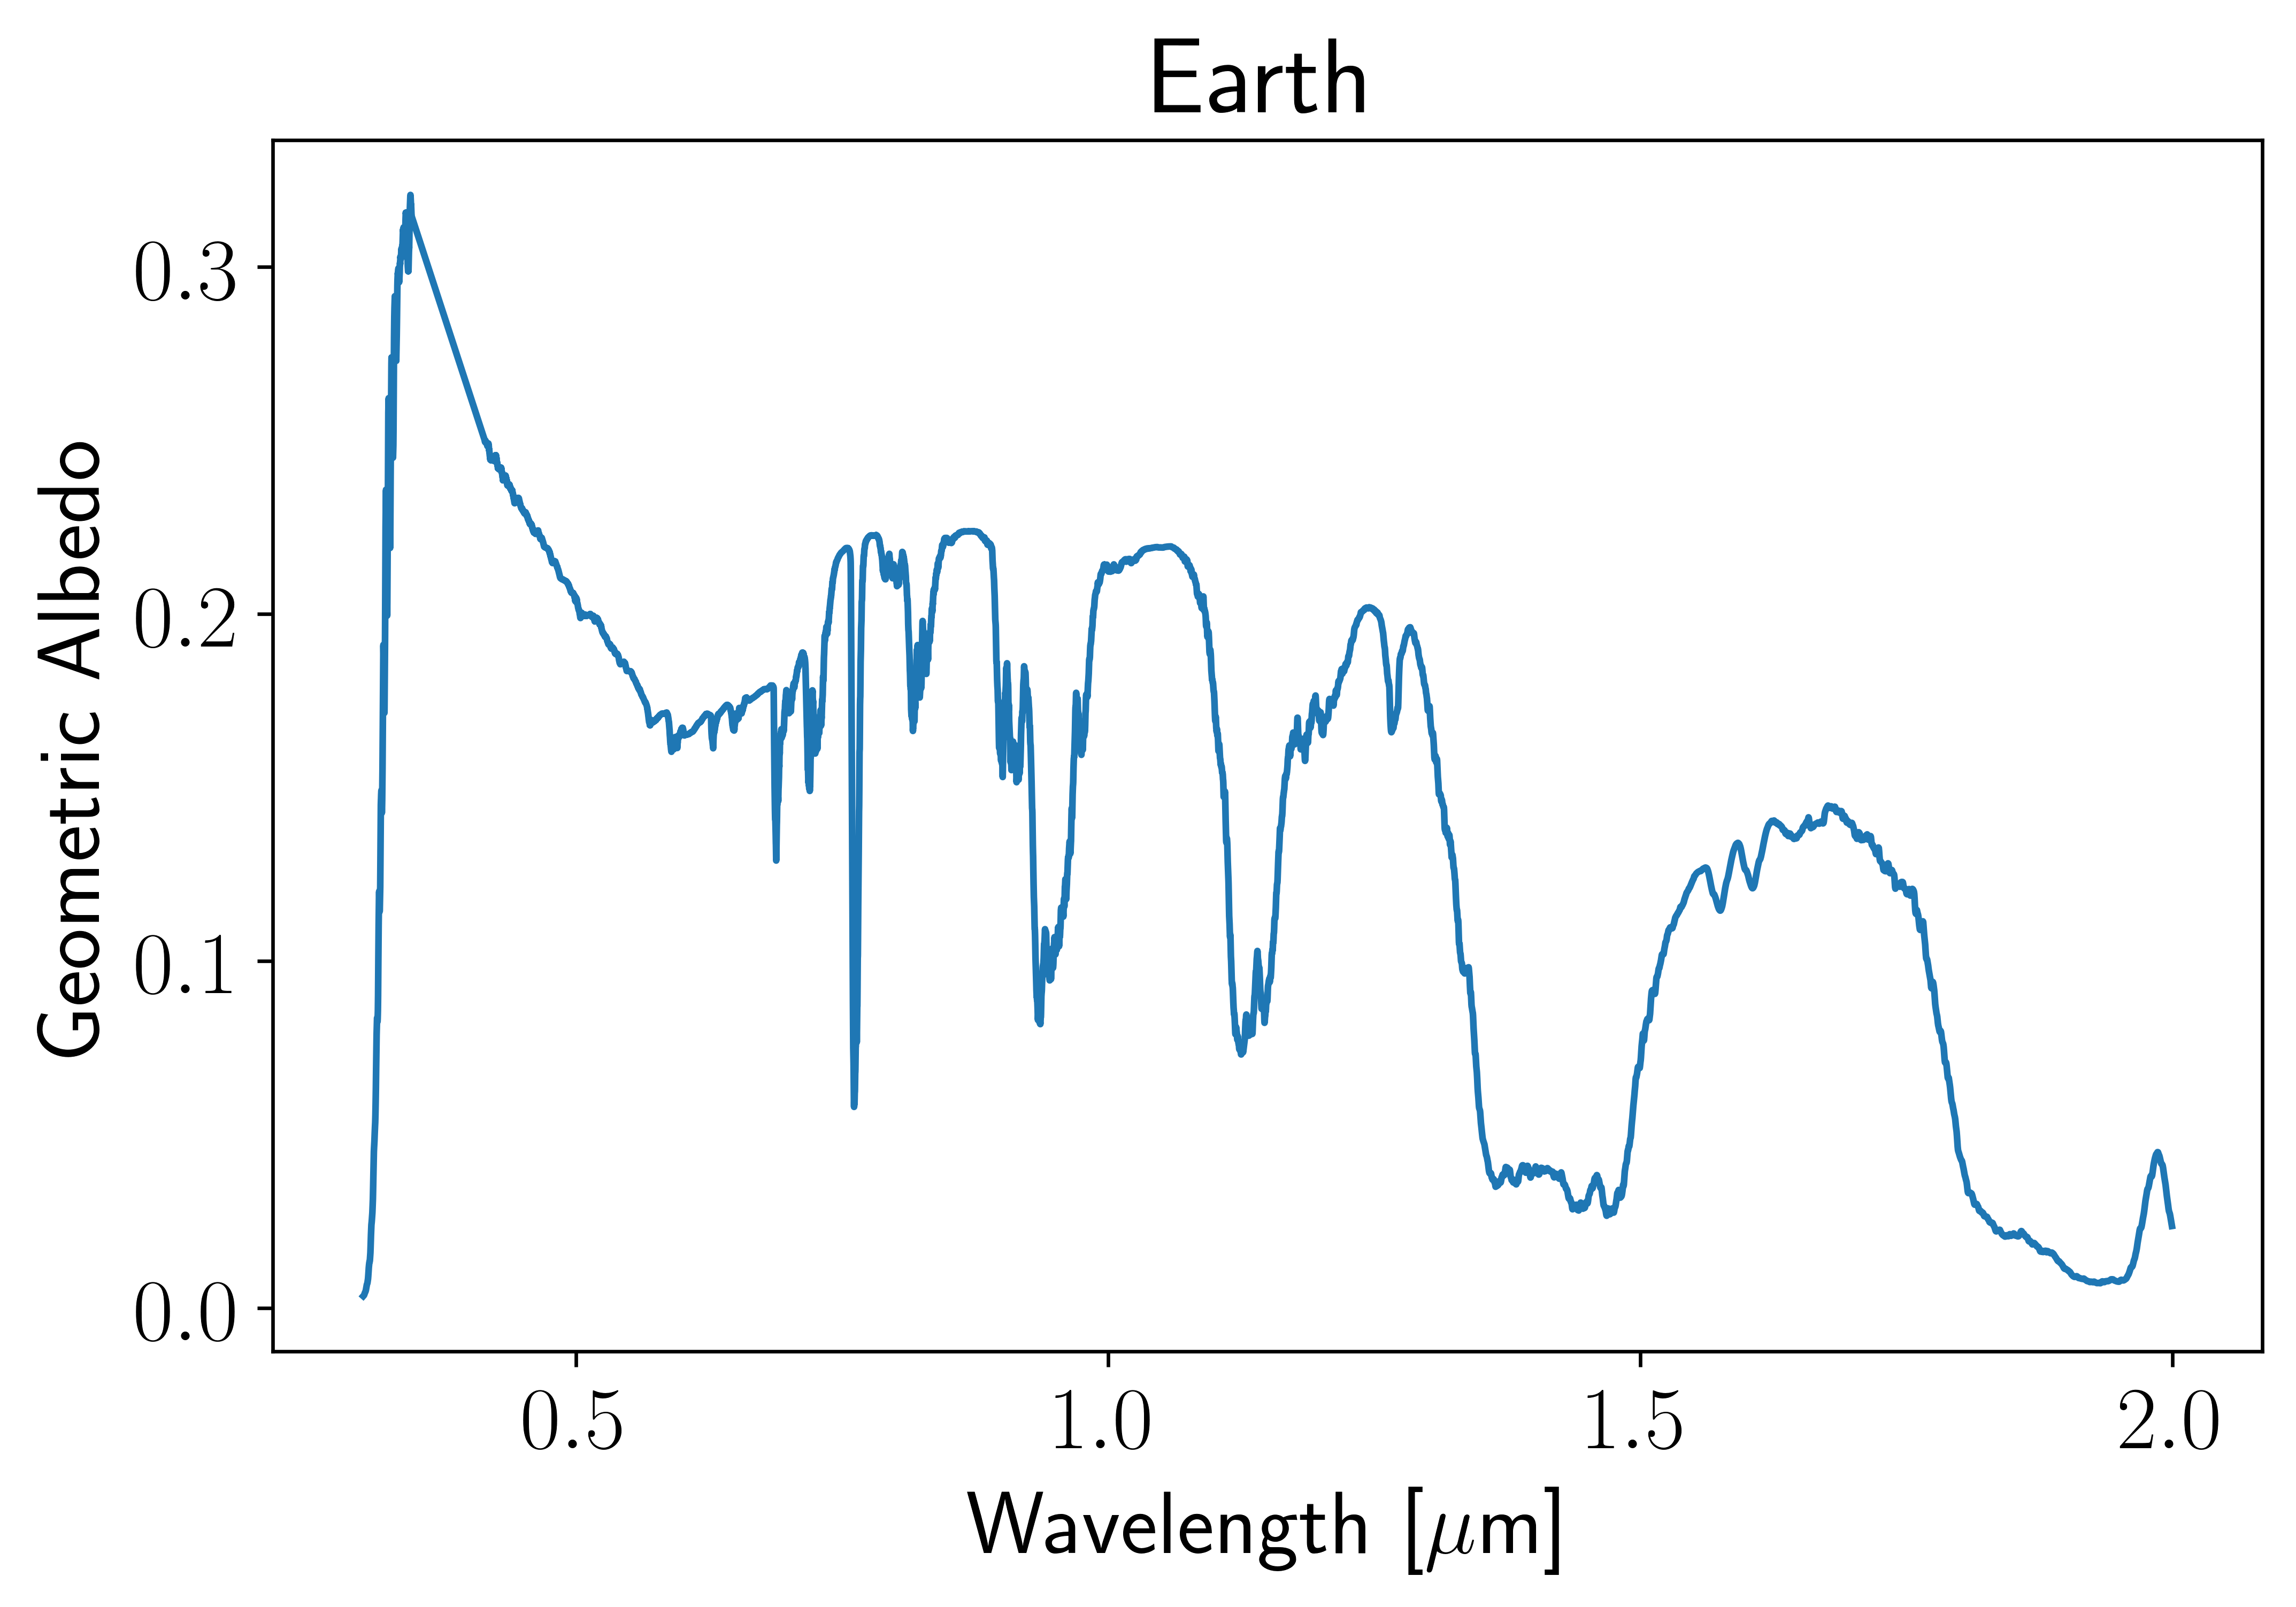

In [9]:
# Create wavelength mask
m = (lamhr > telescope.lammin) & (lamhr < telescope.lammax)

# Plot
plt.plot(lamhr[m], Ahr[m])
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title("Earth");

All we have to do now is calculate the photon count rates incident upon the detector due to the planet and background sources. Just call `count_rates_wrapper` with the spectrum of the planet and star, and initialized `Telescope`, `Planet`, and `Star` objects. 

In [10]:
wantsnr = 10.0
out = cg.count_rates_wrapper(Ahr, lamhr, fstar, telescope, planet, star, wantsnr=wantsnr)

For now the user calculates the background count rate by summing individual noise terms, but in the future this will be done automatically. 

In [11]:
out.cb = (out.cz + out.cez + out.csp + out.cD + out.cR + out.cth)

Finally, we can call `process_noise` to sample Gaussian fake data for a given exposure `time`. This is how we generate a synthetic dataset with realistic noise:

In [12]:
time = 10 # hours

mu, sig, snr = cg.process_noise(time * 60 * 60, out.A, out.cp, out.cb)

The resulting noisey data look like this:

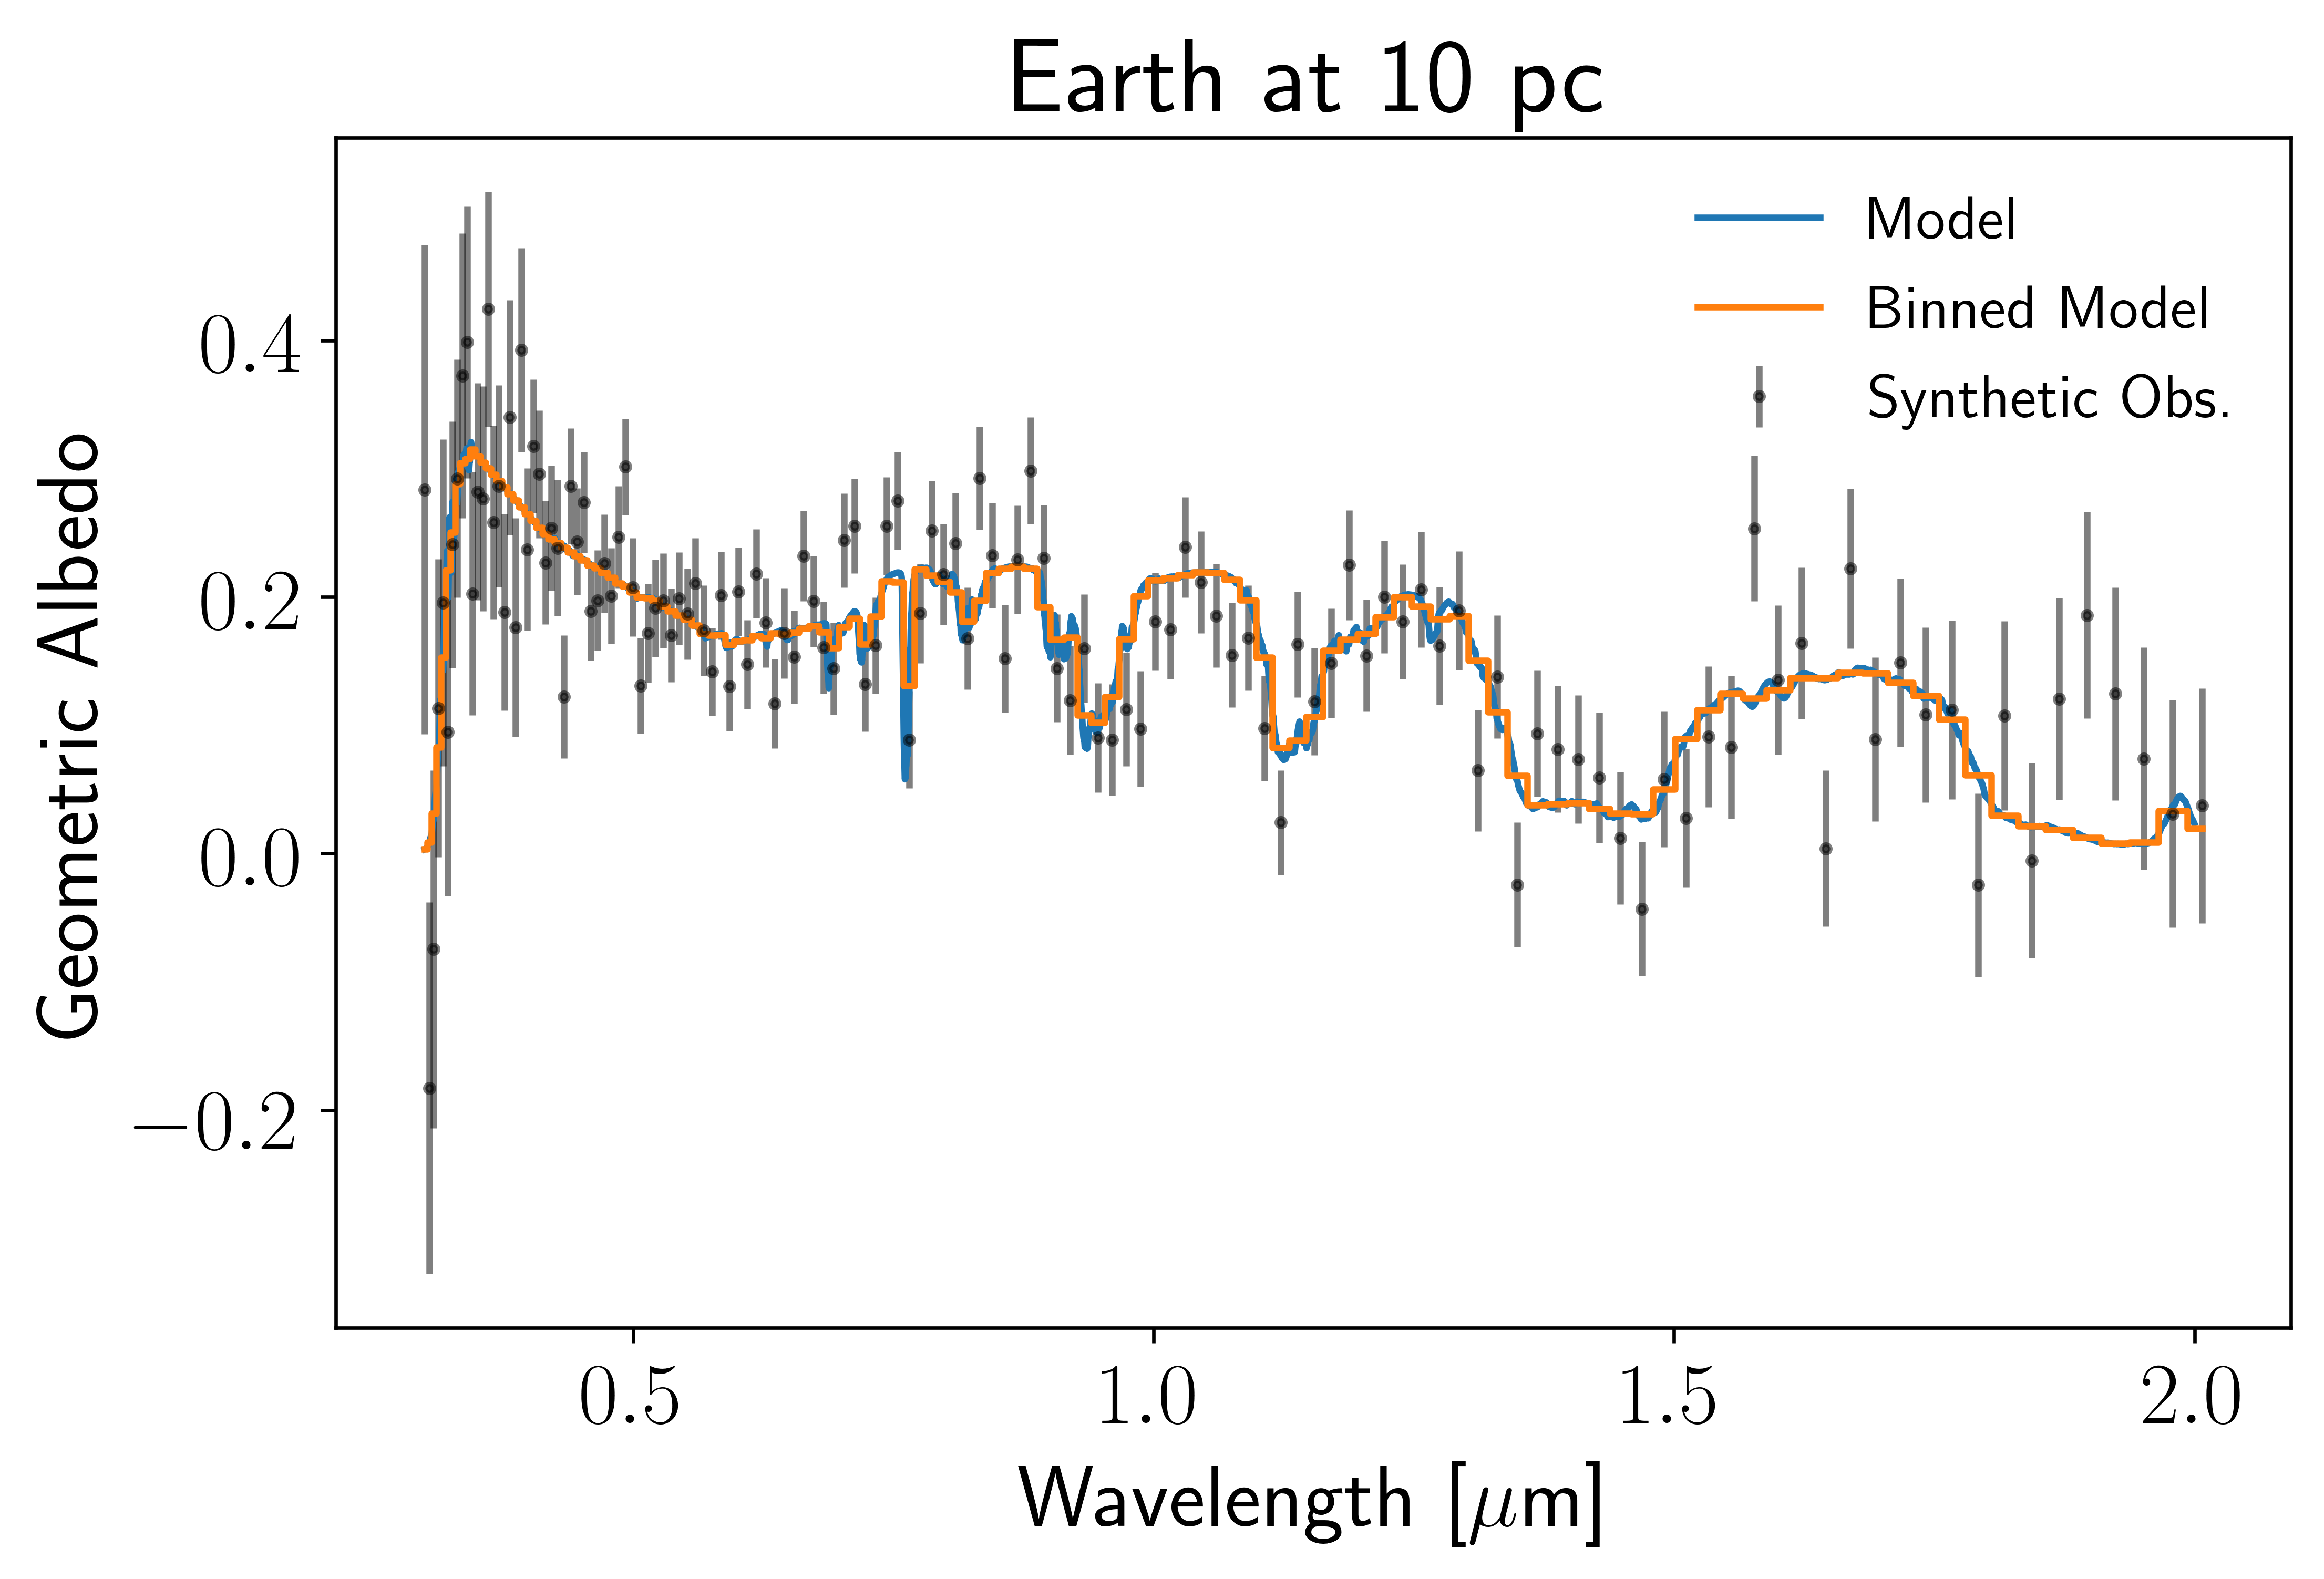

In [13]:
plt.plot(lamhr[m], Ahr[m], label = "Model")
plt.plot(out.lam, out.A, ls = "steps-mid", c = "C1", label = "Binned Model")
plt.errorbar(out.lam, mu, yerr=sig, fmt = "ok", ms = 2, alpha = 0.5, label = "Synthetic Obs.")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
leg = plt.legend(fontsize = 14)
leg.get_frame().set_alpha(0.0)
plt.title("Earth at %i pc" %planet.distance);

The above plot gives us a quick look at the data quality that we might expect for an observation using the telescope and system setup. These data can be saved and used in retrieval tests to see if the true underlying atmospheric structure of the Earth can be extracted.  

It's also useful to look at the signal-to-noise (S/N) ratio in each spectral element to see what wavelengths we are getting the highest S/N: 

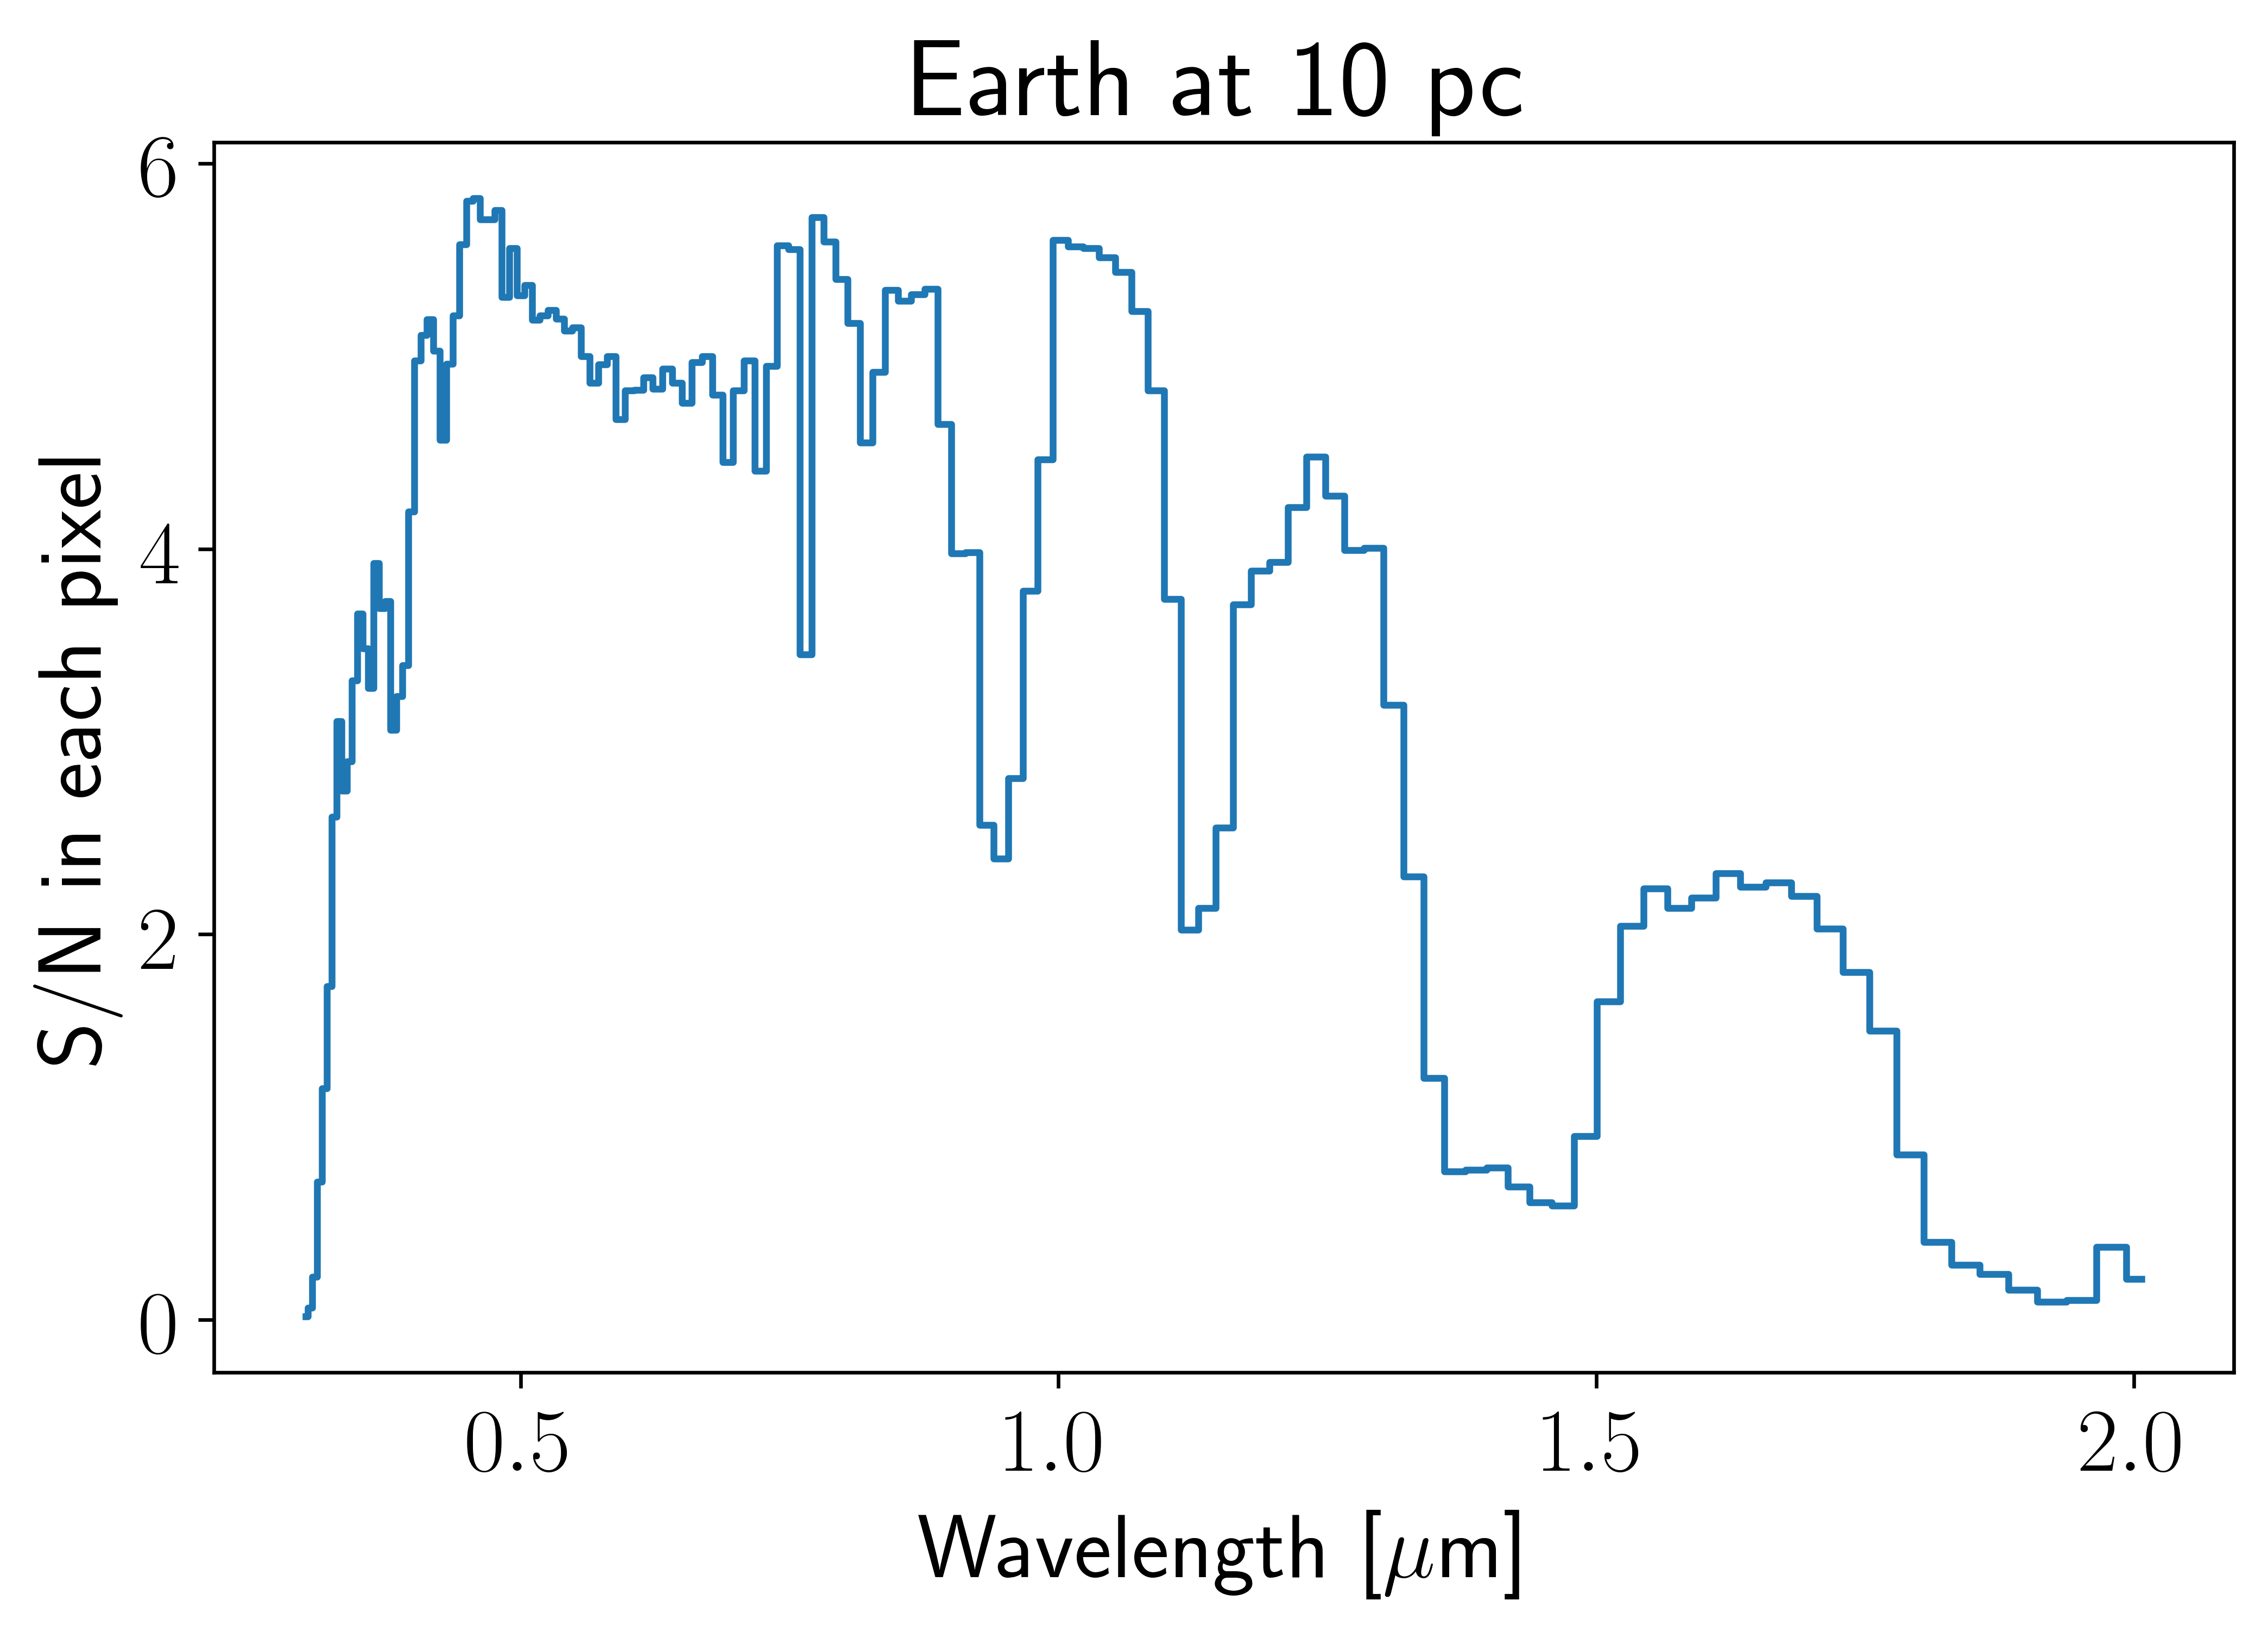

In [14]:
plt.plot(out.lam, snr, ls = "steps-mid")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("S/N in each pixel")
plt.title("Earth at %i pc" %planet.distance);

We can see that the S/N has the same general shape as the stellar SED. We are, after all, observing stellar light reflected off a planet. As a result, the S/N is the highest where the Sun outputs the most photons: around 500 nm. But the S/N is not just the stellar SED, it is the stellar SED *convolved with the planet's reflectivity*. So we get lower S/N in the bottom of molecular absorption bands and higher S/N in the continuum between the bands. The peak in S/N near 0.75 µm is due to the increase in albedo of the Earth's surface (particularly land and vegetation) at that wavelength compared to shorter wavelengths where the Sun emits more photons. 

Finally, let's take a look at the exposure time necessary to achieve a given signal-to-noise ratio (`wantsnr`).  

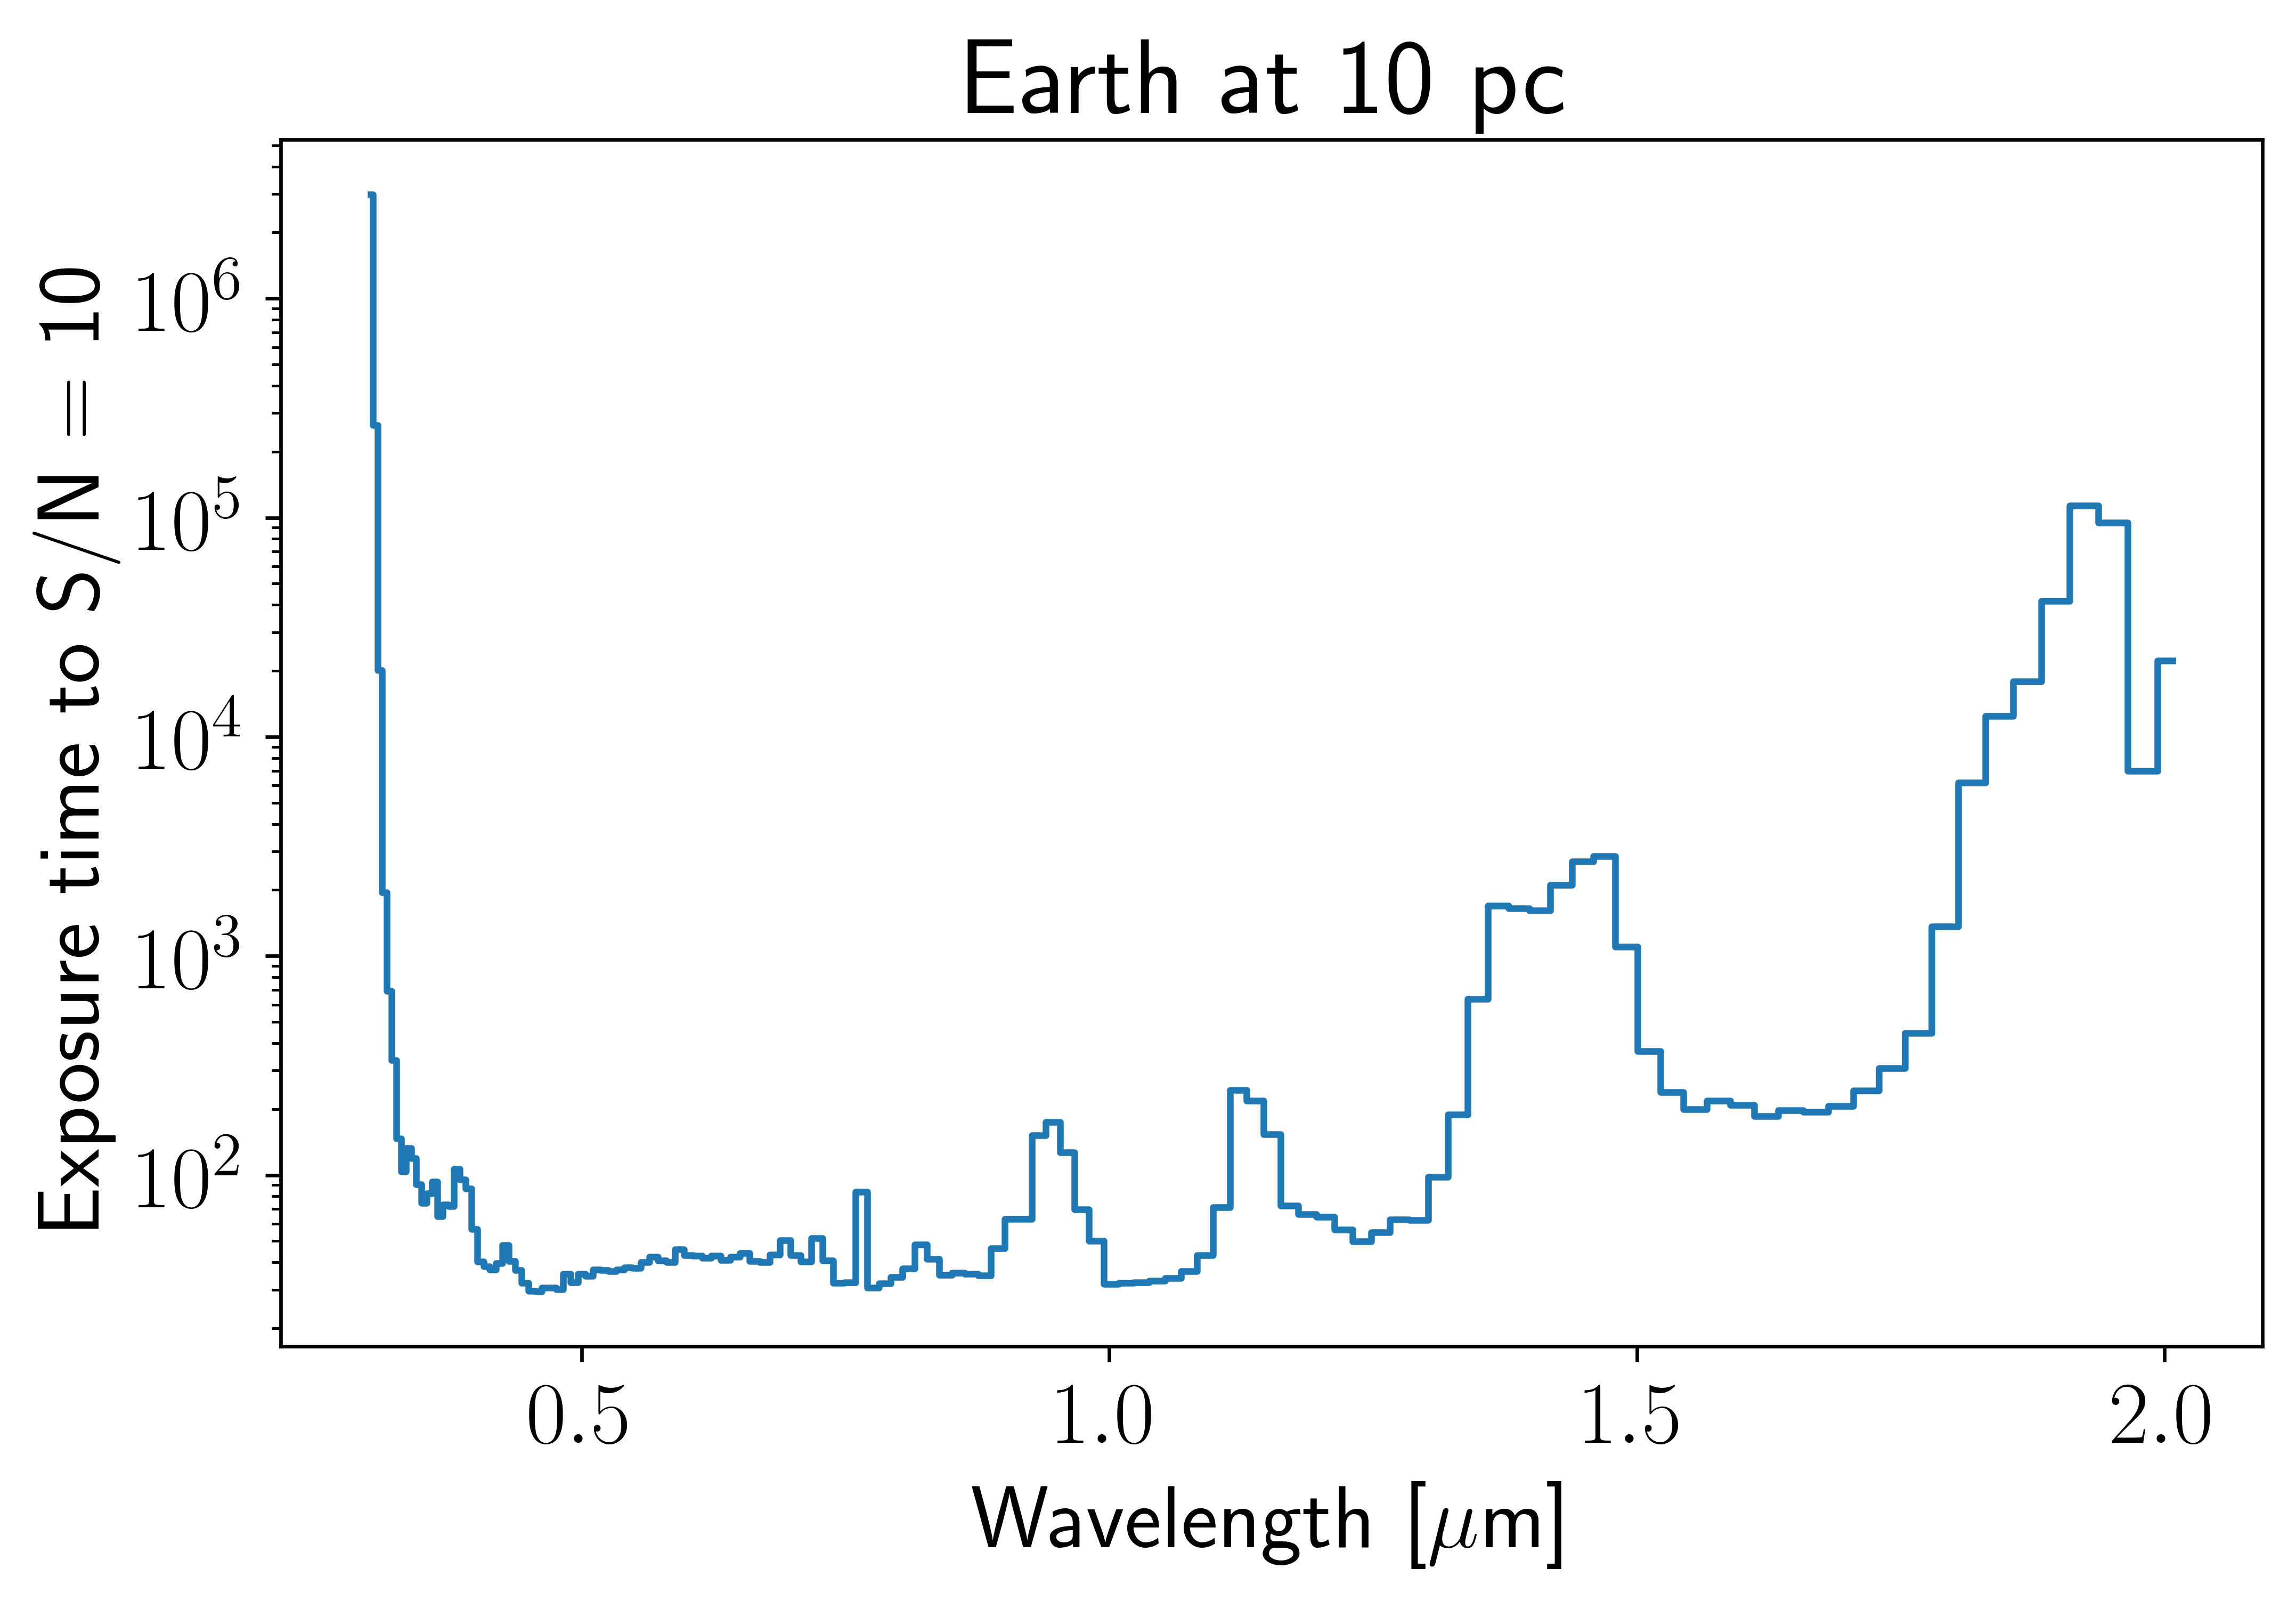

In [15]:
plt.plot(out.lam, out.DtSNR, ls = "steps-mid")
plt.yscale("log")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Exposure time to S/N = %i" %wantsnr)
plt.title("Earth at %i pc" %planet.distance);

The exposure time in each spectral element is inversely proportional to the S/N squared, $t_{\text{exp}} \propto (\text{S/N})^{-2}$, so this plot is inverted compared to the last one. Here we see that ridiculously infeasible exposure times are required to achieve high S/N at the wavelengths were fewer photons are reflected off the planet. Of course, this is all assuming that the exoplanet we are looking at *is* Earth. This is an extremely useful benchmark calculation to make (let's make sure we build a telescope capable of studying an exact exo-Earth), but as we see in this example, the spectrum, exposure time, and S/N are all quite dependent on the nature of the exoplanet, which we won't know *a priori*. So go forth and use this model with your own simulated exoplanet spectra to see what a future telescope can do for you!   